# Problem 1 : Implement Neural Network from scratch 
### (a) - Downloading the MNIST dataset

In [1]:
import torchvision as thv
train = thv.datasets.MNIST('./data' , download=True , train=True) 
val = thv.datasets.MNIST('./data', download=True, train=False) 
print(train.data.shape, len(train.targets))

torch.Size([60000, 28, 28]) 60000


In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.utils.data
import random
import torchvision.transforms as transforms
from numpy import linalg
import matplotlib.pyplot as plt

In [3]:
print(train.data.shape[0])
print(val.data.shape[0])

60000
10000


In [4]:
# to read the data into numpy format
train_np = train.data.numpy()
val_np = val.data.numpy()

# read the corresponding train and target label into numpy format
t_target = train.targets.numpy()
v_target = val.targets.numpy()

# sampling the indices randomly in the range of 0-59999 for the train set and 0-9999 for the test set.
train_sample = np.arange(60000)
test_sample = np.arange(10000)

train_sample_index = np.random.choice(train_sample, 30000, replace=False)
test_sample_index = np.random.choice(test_sample, 5000, replace=False)

sample_train_target = [np.take(train_np,train_sample_index,axis=0), np.take(t_target, 
                                                                            train_sample_index,axis=0)]
sample_test_target = [np.take(val_np,test_sample_index,axis=0), np.take(v_target, 
                                                                            test_sample_index,axis=0)]
print(len(sample_train_target[1]))
print(len(sample_test_target[0][0]))

30000
28


In [5]:
train_data = np.array(sample_train_target[0])
train_target = np.array(sample_train_target[1])

test_data = np.array(sample_test_target[0])
test_target = np.array(sample_test_target[1])

# performing min-max normalization to normalize train and test input data between 0 and 1
train_data = (train_data - np.min(train_data))/(np.max(train_data) - np.min(train_data))
test_data = (test_data - np.min(test_data))/(np.max(test_data) - np.min(test_data))

### (b) - Implementing Linear Layer

In [6]:
class LinearLayer_t : 
    def __init__ ( self ) : 
        self.w=np.random.normal(0,1, size=(784,10)) # number of classes=784,class lables=10
        self.b=np.random.normal(0,1, size=(1,10)) # bias for each neuron so it's deminesion is 1x10
        
        # performing L2 norm on w and b using linalg
        norm_w2=1/(np.linalg.norm(self.w,2))
        norm_b2=1/(np.linalg.norm(self.b,2))
        
        self.w = (norm_w2)*(self.w)
        self.b = (norm_b2)*(self.b)
    
    def forward(self , a_prev): 
        # performing linear trasformation i.e z=wx+b
        a_curr = np.dot(a_prev,self.w)+self.b
        self.a_prev = a_prev
        return a_curr

    def backward(self , da): 
        da_prev=da.dot((self.w).T)
        self.dw=((self.a_prev).T).dot(da)
        self.db=np.sum(da,axis=0,keepdims=True)/batch_size
        return da_prev

    def zero_grad( self ):
        self.dw = np.zeros(self.dw.shape)
        self.db = np.zeros(self.db.shape)

### (c) - Implemented ReLU layer

In [7]:
class Relu_t:
    def __init__(self):
        pass
        
    def forward(self, a):
        # forward function of ReLU= max(0,a)
        b=np.maximum(0,a)
        self.a=b
        return b
    
    def backward(self,dz):
        self.a[self.a<=0]=0
        self.a[self.a>0]=1
        self.dz=dz*self.a
        return self.dz
    
    def zero_grad(self):    
        self.dz = np.zeros(self.dz.shape)
        

### (d) - Combined Softmax and Cross-entropy layer

In [8]:
class SoftmaxCrossEntropy_t: 
    def __init__(self):
        pass
    
    def forward(self,z,yhat): 
        self.yhat=yhat
        sum_exp=np.sum(np.exp(z),axis=1,keepdims=True)
        # calculating SoftMax(Z)
        y_pred = np.exp(z)/ sum_exp 
        # calculating the cross entropy loss
        loss = -np.sum(yhat*np.log(y_pred),axis=1,keepdims=True)
        self.y_pred = y_pred
        n=np.shape(loss)[0]
        # calculating average loss
        avg_loss=np.sum(loss,axis=0,keepdims=True)/(n)
        return y_pred, avg_loss

    def backward(self):
        self.dz = self.y_pred - self.yhat
        return self.dz

    def zero_grad(self):
        self.dz=np.zeros_like(self.dz)

In [9]:
def mini_batch_sampling(data, target):
    data_arange=np.arange(data.shape[0])
    batch_index = np.random.choice(data_arange, data.shape[0], replace=False)
    input_data_batch=np.take(data,batch_index, axis=0)
    target_batch=np.take(target,batch_index, axis=0)
    
    return input_data_batch, target_batch

### (e), (f), and (g) - Checking the forward and backward pass for batch size=1 and Training the Neural Network

In [16]:
l1 = LinearLayer_t()
l2 = Relu_t()
l3 = SoftmaxCrossEntropy_t()

epochs=240
batch_size = 32
eta=0.01

train_acc_list=[]
test_acc_list=[]

batch_train_acc=[]
batch_val_acc=[]

epoch_train_loss=[]
epoch_val_loss=[]

train_error=[]
val_error=[]

# performing One hot encoding on the train lables
one_hot=np.zeros((train_target.size, 10))
one_hot[np.arange(train_target.size), train_target]=1

# performing One hot encoding on the test lables
one_hot_test=np.zeros((test_target.size, 10))
one_hot_test[np.arange(test_target.size), test_target]=1

for epoch in range(epochs):
    train_acc=0
    test_acc=0
    train_loss=[]
    val_loss=[]
    x, x_label=mini_batch_sampling(train_data,one_hot)
    batch_id=0
    for batch_id in range(0,x.shape[0],batch_size):
        if (batch_id + batch_size) > (x.shape[0]):
            train_batch_data = x[batch_id:x.shape[0],...]
            train_batch_label = x_label[batch_id:x_label.shape[0],...]
            batch_id = x.shape[0]
        else:
            train_batch_data = x[batch_id:(batch_id+batch_size),...]
            train_batch_label = x_label[batch_id:(batch_id+batch_size),...]
            batch_id = batch_id+batch_size
    
        x_input = train_batch_data.reshape(train_batch_data.shape[0], 784)
        yhat=train_batch_label

        out1 = l1.forward(x_input)
        out2 = l2.forward(out1)
        pred,out3 = l3.forward(out2, yhat)
        
        prediction = np.argmax(pred, axis=1)
        ground_truth = np.argmax(yhat, axis=1)

        train_acc += np.count_nonzero(prediction==ground_truth)
        batch_train_acc.append((train_acc/30000)*100)
        train_loss.append(out3[0])
        
        i3 = l3.backward()
        i2 = l2.backward(i3)
        i1 = l1.backward(i2)

        dw=l1.dw/batch_size
        db=l1.db/batch_size

        l1.w=l1.w - eta*dw
        l1.b=l1.b - eta*db

        l1.zero_grad()
        l2.zero_grad()
        l3.zero_grad()
    
    train_acc=(train_acc/30000)*100
    train_acc_list.append(train_acc)
    train_error.append(100-train_acc)
    epoch_train_loss.append(np.mean(train_loss))
    
    s_test_data, s_test_target=mini_batch_sampling(test_data,one_hot_test)
    for batch_id in range(0,s_test_data.shape[0],batch_size):
        if (batch_id + batch_size) > (s_test_data.shape[0]):
            test_batch_data = s_test_data[batch_id:s_test_data.shape[0],...]
            test_batch_label = s_test_target[batch_id:s_test_target.shape[0],...]
            batch_id = s_test_data.shape[0]
        else:
            test_batch_data = s_test_data[batch_id:(batch_id+batch_size),...]
            test_batch_label = s_test_target[batch_id:(batch_id+batch_size),...]
            batch_id = batch_id+batch_size
    
        x_input = test_batch_data.reshape(test_batch_data.shape[0], 784)
        yhat=test_batch_label

        out1 = l1.forward(x_input)
        out2 = l2.forward(out1)
        pred,out3 = l3.forward(out2, yhat)
        
        prediction = np.argmax(pred, axis=1)
        ground_truth = np.argmax(yhat, axis=1)

        test_acc += np.count_nonzero(prediction==ground_truth)
        
        val_loss.append(out3[0])
        
    test_acc=(test_acc/5000)*100
    test_acc_list.append(test_acc)
    val_error.append(100-test_acc)
    epoch_val_loss.append(np.mean(val_loss))
    
print("Train Accuracy: ",train_acc)
print("Test Accuracy: ",test_acc)

Train Accuracy:  93.41333333333334
Test Accuracy:  92.02


In [ ]:
# plot of training/validation loss vs number of iterations
fig1 = plt.figure(figsize=(10,5))
plt.subplot(1,1,1)
plt.plot(train_loss, color='g', label="Train Loss")
plt.plot(val_loss, color='r', label="Test Loss")
leg = plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('Loss value')

print("Max train loss",max(train_loss))
print("Min train loss",min(train_loss))

Max train accuracy 93.41333333333334
Max test accuracy 92.04
240


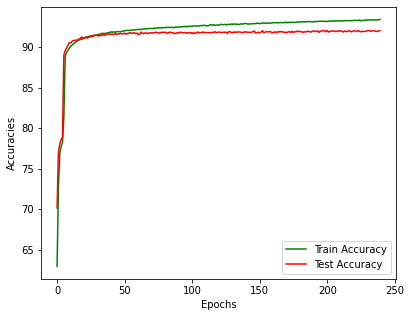

In [18]:
# plot of training/testing accuracy vs number of epochs
fig1 = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train_acc_list, color='g', label="Train Accuracy")
plt.plot(test_acc_list, color='r', label="Test Accuracy")
leg = plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
print("Max train accuracy",max(train_acc_list))
print("Max test accuracy",max(test_acc_list))
print(len(train_acc_list))

Text(0, 0.5, 'Loss')

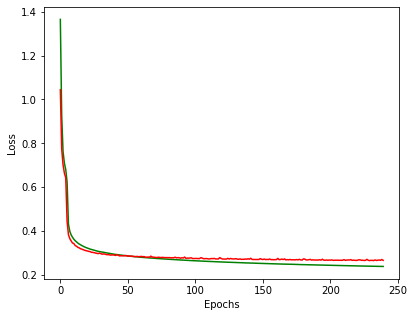

In [19]:
# plot of training/validation loss vs number of epochs
fig1 = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epoch_train_loss, color='g', label="Training loss")
plt.plot(epoch_val_loss, color='r', label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

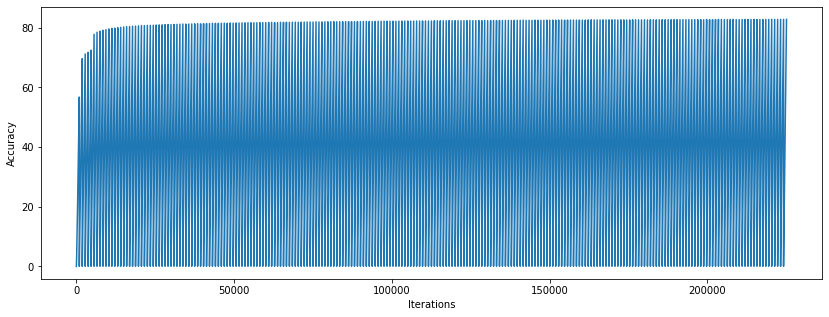

In [14]:
fig1 = plt.figure(figsize=(14,5))

plt.subplot(1,1,1)
plt.plot(batch_train_acc)
# plt.plot(epoch_val_loss, color='r')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Error')

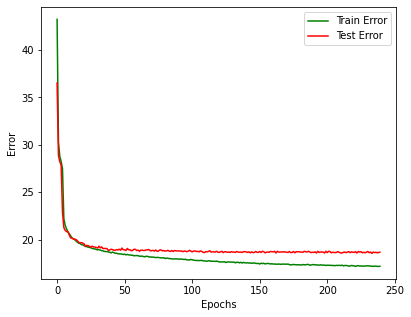

In [15]:
# plot of training/validation error vs number of epochs
fig1 = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train_error, color='g', label="Train Error")
plt.plot(val_error, color='r', label="Test Error")
leg = plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Error')